In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor

# Load the dataset
df = pd.read_csv('airbnb_sample_landmarks_mta_zipcodes.csv')

### Data Cleaning

Check for missing data values

In [2]:
# check for missing values
df.isna().sum()

id                              0
last_scraped                    0
latitude                        0
longitude                       0
accommodates                    0
                             ... 
num_landmarks_dist_500m         0
closest_landmark                0
mean_log_dist_landmarks         0
median_log_dist_landmarks       0
zip_code                     2212
Length: 93, dtype: int64

Remove any instances with missing values. Drop transformed value columns and columns that will not be used in the model.

In [11]:
# drop missing values
df.dropna(inplace=True)
# remove all transformed variables from the dataframe
df = df.loc[:,~df.columns.str.contains('log')]
#drop unneeded columns
df = df.drop(columns=['id','last_scraped','latitude','longitude','borough'])

Convert categorical features to categorical data types and create dummy variables for each category.

In [12]:
df['closest_landmark'] = df['closest_landmark'].astype('category')
df['zip_code'] = df['zip_code'].astype(int).astype('category').head()
# get dummies for the closet_landmark
df = pd.get_dummies(df)

Create train-test split data using 80% of instances for the training dataset and the remaining 20% for the test dataset.

In [13]:
# train test split
xTrain, xTest, yTrain, yTest = train_test_split(df.drop(columns=['price']), df.price, test_size=0.2, random_state=42)

#### Random Forest Model

Instantiate a random forest regressor and run a 5-fold cross-validation on the model using both RSME and R-Squared scoring for the models.

In [17]:
rForest = RandomForestRegressor(random_state=5280)
rForest_cv = cross_validate(rForest,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [18]:
print('------Random Forest------')
print(f'Mean R-Squared: {rForest_cv['test_r2'].mean()}   Standard Deviation of R-squared: {rForest_cv['test_r2'].std()}')
print(f'Mean RSME: {-rForest_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-rForest_cv['test_neg_root_mean_squared_error'].std()}')

------Random Forest------
Mean R-Squared: 0.1802182539653216   Standard Deviation of R-squared: 0.0975418407170482
Mean RSME: 400.90213223114563   Standard Deviation of RSME: -132.01542898683354


The large standard deviation of the R-Squared scores from the cross-validation is nearly half the mean R-Squared value from the cross validation. Simiarly, the standard deviation in the RSME scores is also fairly large. This indactess that the model maybe affected by overfitting or that the sample size was not large enough to overcome outlier values present in the data.

#### Decision Tree Model

In [14]:
decisionTree = DecisionTreeRegressor(random_state=5280)
decisionTree_cv = cross_validate(decisionTree,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [20]:
print('------Decision Tree------')
print(f'Mean R-Squared: {decisionTree_cv['test_r2'].mean()}')
print(f'Mean RSME: {-decisionTree_cv['test_neg_root_mean_squared_error'].mean()}')

------Decision Tree------
Mean R-Squared: -0.8928071404525658
Mean RSME: 557.9719394593733


The random forest performed significantly better than the decision tree. As such we will advance the random forest model as the candidate model. The model will be compared to a model using training and test data with the outlier values replaced.

### Comparing Random Forest Without Outliers

Replace all values above the 99th percentile with the 99th percentile value.

In [15]:
# replace price greater than 5000 with 5000
q99 = df['price'].quantile(0.99)
df.loc[df['price'] > q99,'price'] = q99

Create updated train and test datasets

In [16]:
xTrain, xTest, yTrain, yTest = train_test_split(df.drop(columns=['price']), df.price, test_size=0.2, random_state=42)

Run cross-validation on the updated training dataset

In [23]:
rForest_cv = cross_validate(rForest,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [24]:
print(f'Mean R-Squared: {rForest_cv['test_r2'].mean()}   Standard Deviation of R-squared: {rForest_cv['test_r2'].std()}')
print(f'Mean RSME: {-rForest_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-rForest_cv['test_neg_root_mean_squared_error'].std()}')

Mean R-Squared: 0.5904167640789755   Standard Deviation of R-squared: 0.011889250449645524
Mean RSME: 125.88853306125421   Standard Deviation of RSME: -3.1969846648138


The performance of the model was significantly improved with the replacement of the outlier values suggesting that the sample size may not have been large enough to overshadow the outliers. The training and test data without the outlier values will be used for tuning and assessing the model's performance.

### Hyper-parameter Tuning of the Random Forest Model

Try out 15 different hyperparameter setting using random samples of hyperparameter settings for the max depth of the trees, the percentage of features to sample for each tree, and the number of trees to create in the forest.

In [25]:
params = {
    'max_depth':[5,10,15,20,25,30,35,40,45,50],
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'n_estimators': [50,100,150,200,250]
}

rForest_search = RandomizedSearchCV(rForest, n_iter=15, cv=5, scoring= 'neg_root_mean_squared_error', param_distributions= params, random_state=5280)
rForest_search.fit(xTrain,yTrain)

c:\Users\kmgth\Documents\Current Quarter\DS_Tools1\Airbnb Data\airbnb_env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=5280),
                   n_iter=15,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 0.6, 0.7, 0.8,
                                                         0.9, 1.0],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=5280, scoring='neg_root_mean_squared_error')

In [26]:
print(f'Best parameteres: {rForest_search.best_params_}')

Best parameteres: {'n_estimators': 250, 'max_features': 0.4, 'max_depth': 35}


### Training the Tuned Random Forest Model

Run a 5-fold cross validation on the random forest using the best parameters found from the RandomSearchCV and score the models using both RSME and R-Squared.

In [27]:
bestEstimator_cv = cross_validate(rForest_search.best_estimator_,xTrain,yTrain,cv=5,scoring = ['neg_root_mean_squared_error','r2'])

In [28]:
print(f'Mean R-Squared: {bestEstimator_cv['test_r2'].mean()}   Standard Deviation of R-Squared: {bestEstimator_cv['test_r2'].std()}')
print(f'Mean RSME: {-bestEstimator_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-bestEstimator_cv['test_neg_root_mean_squared_error'].std()}')


Mean R-Squared: 0.6079002531866335   Standard Deviation of R-Squared: 0.01368617187256581
Mean RSME: 123.19077582521265   Standard Deviation of RSME: -4.138582384445828


### Assessing the Tuned Model
Test the model's predicted values to the actual values of the test data.

In [29]:
print(f'R-Squared: {r2_score(yTest,rForest_search.predict(xTest))}')
print(f'RSME: {root_mean_squared_error(yTest,rForest_search.predict(xTest))}')

R-Squared: 0.6489014670770777
RSME: 117.18263278819244


The random forest model had an R-Squared value of 0.649 on the test data implying that performs better than random chance at predicting the daily listing price of an Airbnb rental in NYC. This was slighly higer than the R-Square score of 0.601 on the cross validation of the training data. The RSME also decreased on the on the test data implying a that the model does a decent job of predicting the daily price of a listing. Overall this implies that the model is mostly likely not overfitted to the training data and may generalize well.

Run 10 permuations to calculate the permuted feature importance for the random forest model.

In [30]:
perm_imp= \
permutation_importance(estimator= rForest_search.best_estimator_, 
                       n_repeats= 10, 
                       random_state=5280,
                       X= xTest,
                       y= yTest)

Display all permuted feature importance values for all features.

In [31]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
feat_imp=list(zip(xTrain.columns, perm_imp.importances_mean))
# sort by most to least important
feat_imp.sort(key=lambda x: x[1], reverse=True)
feat_imp

[('accommodates', np.float64(0.13112207953779237)),
 ('bedrooms', np.float64(0.11544574166487061)),
 ('bathrooms_cleaned', np.float64(0.10644687007648068)),
 ('high_line_dist', np.float64(0.09055476567127466)),
 ('calculated_host_listings_count_entire_homes',
  np.float64(0.06856660920540816)),
 ('minimum_nights', np.float64(0.04992827689220326)),
 ('whitney_museum_dist', np.float64(0.04298570201824735)),
 ('room_type_Private room', np.float64(0.03491369360098725)),
 ('has_license', np.float64(0.02387110400953152)),
 ('moma_ps1_dist', np.float64(0.02365310973891238)),
 ('room_type_Entire home/apt', np.float64(0.021694544722846765)),
 ('calculated_host_listings_count_private_rooms',
  np.float64(0.020572067215357204)),
 ('madison_square_garden_dist', np.float64(0.01851185352492287)),
 ('instant_bookable', np.float64(0.011094090756419683)),
 ('brooklyn_museum_dist', np.float64(0.008777363594693277)),
 ('empire_state_building_dist', np.float64(0.00789150518228463)),
 ('chrysler_building_d

The most important features for the model are the number of people the listing can acommodate, the number of bedrooms, the number of bathrooms, and the distance to the high line. This suggests that the size of the listing in terms of the number of people it can accomedate is the most important factor is estimating price for the model. The least important features are zip codes in which the listings are located. This suggests that the physical location of the listing itself is unimportant fore predicting the daily price in the model. However, the distances to certain landmarks such as the distance to the high line or the Whitney museum. This implies that the location of the listing does matter in relationship to other locations in the model. 

In [32]:
temp = pd.DataFrame(feat_imp, columns=['Feature','Permuted_Importance'])
temp = temp[temp['Permuted_Importance']>= 0.001]

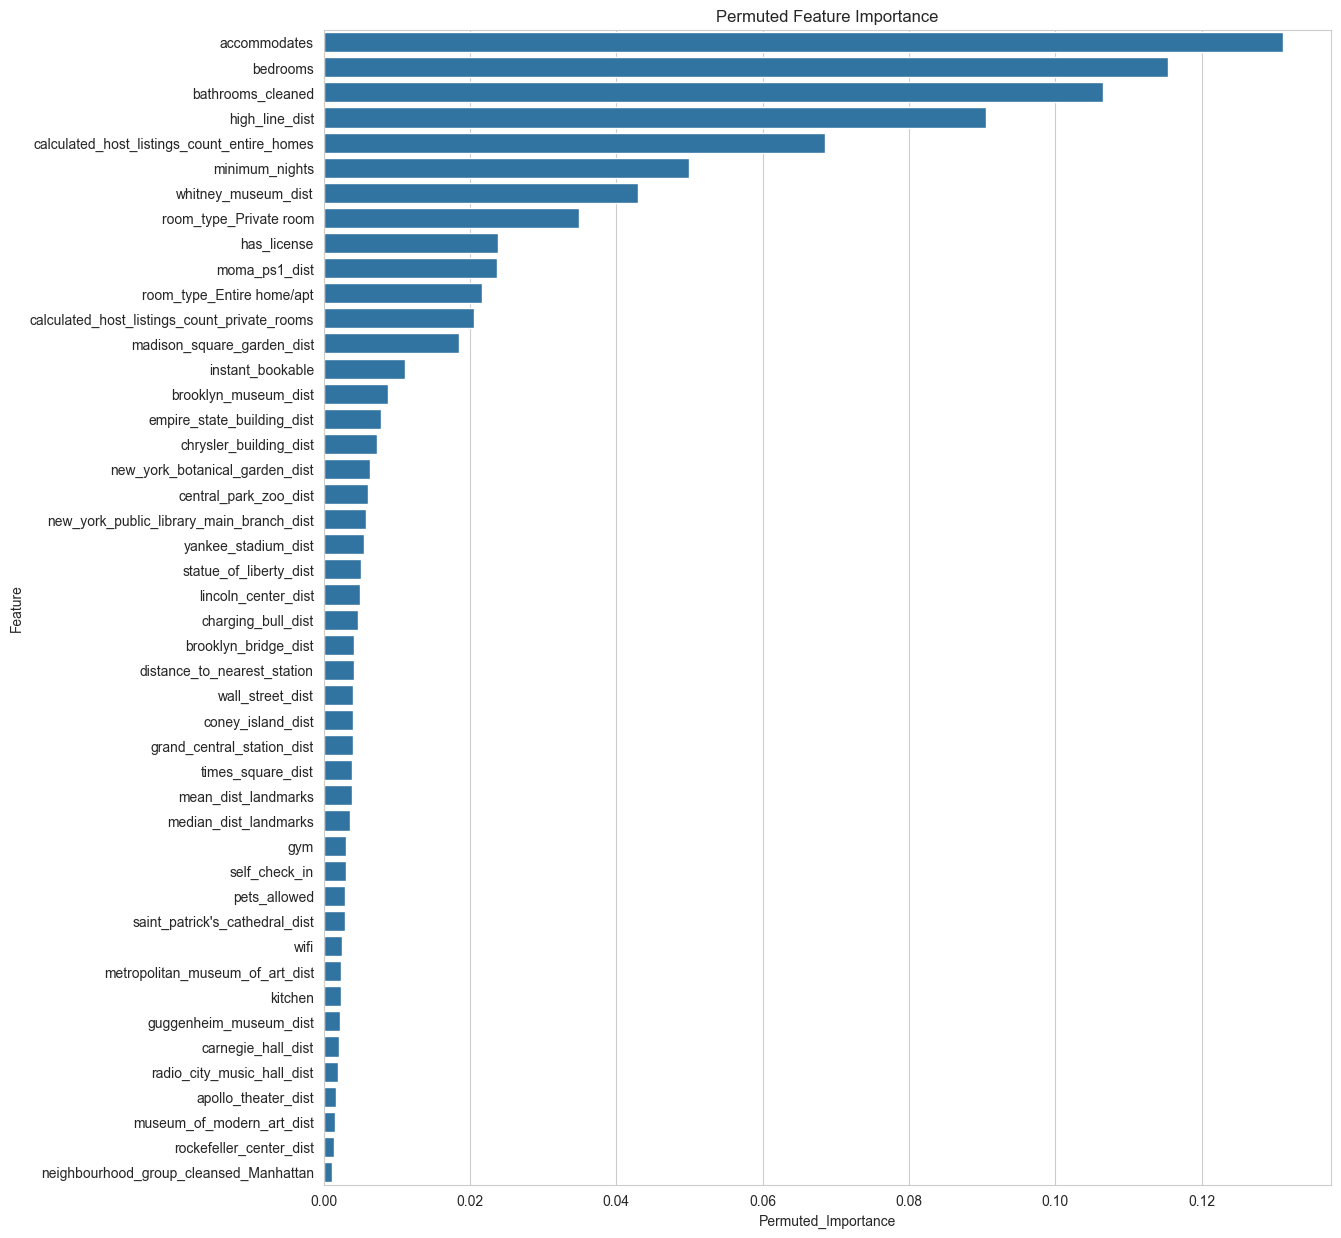

In [33]:
fig = plt.figure(figsize=(13,15))
sns.set_style('whitegrid')
sns.barplot(data=temp, x='Permuted_Importance', y='Feature', orient='h')
plt.title('Permuted Feature Importance')
plt.show()

Based on the permuted feature importance, we may safely remove a number of variables without significantly impacting the performance of the model. This helps to make the model more interpretable and less susceptible to overfitting.

Drop unimportant features for the model.

In [36]:
importFeatures = [
                  'accommodates', 'bedrooms', 'bathrooms_cleaned', 'high_line_dist', 
                  'calculated_host_listings_count_entire_homes','minimum_nights', 
                  'whitney_museum_dist', 'room_type_Private room', 'has_license',
                  'moma_ps1_dist', 'room_type_Entire home/apt', 
                  'calculated_host_listings_count_private_rooms','madison_square_garden_dist', 
                  'instant_bookable','brooklyn_museum_dist', 'empire_state_building_dist', 
                  'chrysler_building_dist', 'new_york_botanical_garden_dist', 'central_park_zoo_dist', 
                  'new_york_public_library_main_branch_dist','yankee_stadium_dist', 
                  'statue_of_liberty_dist', 'lincoln_center_dist', 'charging_bull_dist', 
                  'brooklyn_bridge_dist','distance_to_nearest_station', 'wall_street_dist', 
                  'coney_island_dist', 'grand_central_station_dist', 'times_square_dist',
                  'mean_dist_landmarks','median_dist_landmarks', 'gym','self_check_in', 
                  'pets_allowed', "saint_patrick's_cathedral_dist", 'wifi', 'metropolitan_museum_of_art_dist', 
                  'kitchen', 'guggenheim_museum_dist', 'carnegie_hall_dist', 'radio_city_music_hall_dist', 
                  'apollo_theater_dist', 'museum_of_modern_art_dist', 'rockefeller_center_dist',
                  'neighbourhood_group_cleansed_Manhattan'
]

In [37]:
xTrain2 = xTrain[importFeatures]
xTest2 = xTest[importFeatures]

Retrain the tuned model on the smaller group of features.

In [38]:
rforest_final = RandomForestRegressor(n_estimators=200,max_features=0.4,max_depth=30,random_state=5280)
rforest_final.fit(xTrain2,yTrain)

RandomForestRegressor(max_depth=30, max_features=0.4, n_estimators=200,
                      random_state=5280)

Verify that the smaller number of features did not significantly impact the performance of the model.

In [40]:
print(f'R-Squared: {r2_score(yTest,rforest_final.predict(xTest2))}')
print(f'RSME: {root_mean_squared_error(yTest,rforest_final.predict(xTest2))}')

R-Squared: 0.6531897831225904
RSME: 116.46480005365032


After dropping the unimportant features the R-Square rose slightly and the RSME decreased slightly. This implies that the model may have been effected by the presence of the unimportant features and removing them made the model slightly more generalizable. 

### Conclusion
The random forest model performed moderately well at predicting the daily price of the an NYC Airbnb listing. The model tended to place more importance on features related to the size of the listing such as the number of people it can accomedate, the number of bedrooms, the number of bathrooms, and the type of room. The random forest did not find any of the zip codes or the borough the property was located in to be important for predicting the daily price. However, the model did find the distances to certain landmarks important. This suggests the that the physical location of the listing may be less important than it's proximity to specific landmarks for the model. The minimum number of nights required for the booking, the number of private rooms and the number of entire houses/apt that a host has listed also all had more importance than other features. This implies that the host's decision have an relationship to the price of a listing. Based on the model, the price of the listing appears to be related more strongly with its proximity to landmarks and the size of the accomedation rather than amenties offered or the location of the property itself.

### Future Work
To improve the robustness of the model, the sample size of Airbnb listing should be expanded to include more listing.  This would help the model make more accurate predictions on more extreme price values which were excluded from this analysis. Another area to explore could be the inclusion of time such as seasonally in the model. An additional improvement to the model could be further limiting the number of variables used for the random forest.